In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CiberSecurityLab/lab1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CiberSecurityLab/lab1


# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

In [54]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("./Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1080


## Group Number : 5

## Student 1 
### Name : Chaoyi Zhu
### ID : 5500524

## Student 2
### Name : Zhiyang Liu
### ID : 5534496

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import re
import os

## 1. Visualization task – 1 A4

### 1a. Plot visualizations
### Data preprocessing

In [6]:
# Load the data
df_src = pd.read_csv(os.path.join('data', 'train_data.csv'))

# Number of Transactions
print("================= Number of Transactions =================")
print("Number of rows = " + str(len(df_src.index)))
print("Number of fraudulent transactions = " + str(len(df_src.loc[df_src['label'] == 1])))
print("Number of valid transactions = " + str(len(df_src.loc[df_src['label'] == 0])))

# Show part of the sample data
print("================= Show part of the sample data =================")
display(df_src.head(5))

def data_preprocessing(df_src):
    # Preprocessing the data
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df_src['card_id'])
    df_src['card_id'] = card_enc.transform(df_src.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df_src['ip_id'])
    df_src['ip_id'] = ip_enc.transform(df_src.ip_id)

    # 3.Remove NA values
    df_src.loc[df_src['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df_src.loc[df_src['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df_src.loc[df_src['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

    # 4.Country code
    unique_issuer_cc = df_src['issuercountrycode'].unique()
    unique_shopper_cc = df_src['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df_src['issuercountrycode'] = enc.transform(df_src.issuercountrycode)
    df_src['shoppercountrycode'] = enc.transform(df_src.shoppercountrycode)

    # 5.Change currency to EUR
    def conv(row):
        currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                         "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                         "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                         "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                         "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                         "CNY": 7.5541, "SEK": 10.635}
        return row['amount'] / (currency_dict[row['currencycode']]*100)
    df_src['amount_eur'] = df_src.apply(lambda x: conv(x), axis=1)

    # 6.Tx-variantcode
    enc1 = LabelEncoder()
    enc1.fit(df_src['txvariantcode'])
    df_src['txvariantcode'] = enc1.transform(df_src.txvariantcode)

    # 7.Currency code
    enc2 = LabelEncoder()
    enc2.fit(df_src['currencycode'])
    df_src['currencycode'] = enc2.transform(df_src.currencycode)

    # 8.Shopper interaction
    enc3 = LabelEncoder()
    enc3.fit(df_src['shopperinteraction'])
    df_src['shopperinteraction'] = enc3.transform(df_src.shopperinteraction)

    # 9.Cache accountcode_cc
    df_src['accountcode'] = df_src['accountcode'].apply(lambda x: re.sub('Account','',x))
    df_src['accountcode_cc'] = 0
    df_src.loc[(df_src['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
    df_src.loc[(df_src['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
    df_src.loc[(df_src['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
    df_src.loc[(df_src['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

    # 10.Account code
    enc4 = LabelEncoder()
    enc4.fit(df_src['accountcode'])
    df_src['accountcode'] = enc4.transform(df_src.accountcode)

    # 11.Card verification code supplied
    enc5 = LabelEncoder()
    enc5.fit(df_src['cardverificationcodesupplied'])
    df_src['cardverificationcodesupplied'] = enc5.transform(df_src.cardverificationcodesupplied)

    # 12. Mail id
    df_src.loc[df_src['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df_src['mail_id'])
    df_src['mail_id'] = enc6.transform(df_src.mail_id)

    # Validation result of CVC/CVV2
    df_src.loc[df_src['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

    # Feature Engineering
    df_src['countries_equal'] = (df_src['shoppercountrycode'] == df_src['issuercountrycode'])
    df_src.loc[df_src['countries_equal'] == False,'countries_equal'] = 0
    df_src.loc[df_src['countries_equal'] == True,'countries_equal'] = 1
    return df_src

df_src = data_preprocessing(df_src)
# show data after processing
print("=================Processed data=================")
display(df_src.head(10))

================= Number of Transactions =================
Number of rows = 189628
Number of fraudulent transactions = 276
Number of valid transactions = 189352
================= Show part of the sample data =================


,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


=================Processed data=================


,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1
5,8,49,8,475130.0,2325.0,1,49,0,0,0,3,17723,73821,96349,0,26.957147,GB,1
6,10,49,8,446291.0,10050.0,1,49,1,1,1,3,43402,65524,109435,0,116.524441,GB,1
7,11,49,8,446238.0,7000.0,1,49,1,1,1,3,82674,121644,64458,0,81.161302,GB,1
8,12,49,8,465943.0,5195.0,1,49,1,1,1,3,157111,160643,133779,0,60.233281,GB,1
9,13,49,8,475714.0,15000.0,1,49,1,1,1,3,161166,144211,119109,0,173.917076,GB,1


### (1) Transaction Amount
The transaction amount is the most important metric for transactions. As shown in this chart, we plot the transaction amounts of benign transactions and fraudulent transactions in a box plot

[Text(0.5, 1.0, 'Transaction Amount')]

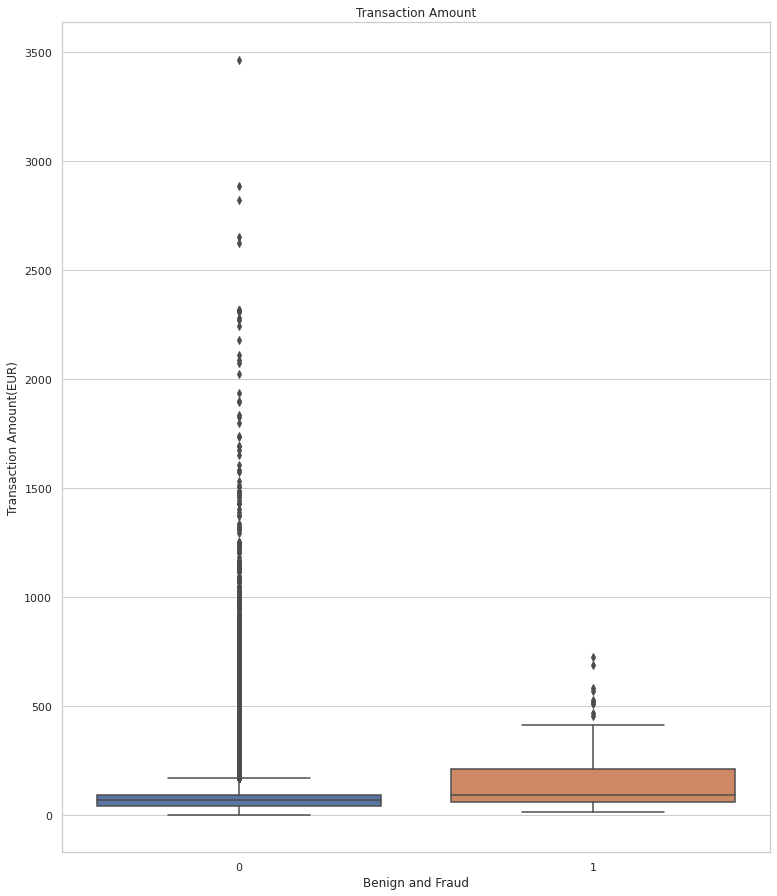

In [7]:
df_amount = df_src[['label', 'amount_eur']]
sns.set(rc={'figure.figsize':(12.7,15.27)})
sns.set_style("whitegrid")

ax = sns.boxplot(x='label',y='amount_eur', data=df_amount)
ax.set(xlabel = "Benign and Fraud")
ax.set(ylabel = "Transaction Amount(EUR)")
ax.set(title = "Transaction Amount")

From this chart, we can see that the fraudulent transactions have a higher average transaction amount than the benign transactions.

### (2) countries equal
In the visualization example, a column of if the shopper country and issuer country are the same is added. Therefore, we want to test if the column is useful. We plot two pie charts to show the percentage of the shopper country and issuer country are equal in the fraudulent and benign transactions.

In [8]:
df_ctr_equal = df_src[['label', 'countries_equal']]
df_ctr_equal = df_ctr_equal.value_counts()
df_ctr_equal = df_ctr_equal.to_numpy()

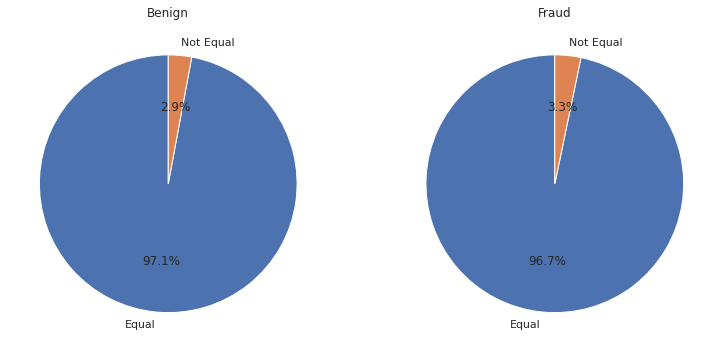

In [9]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,10)})
plt.subplot(1,2,1)
plt.pie(df_ctr_equal[:2], labels=['Equal', 'Not Equal'], autopct='%1.1f%%', startangle=90)
plt.title('Benign')
plt.subplot(1,2,2)
plt.pie(df_ctr_equal[2:], labels=['Equal', 'Not Equal'], autopct='%1.1f%%', startangle=90)
plt.title('Fraud')
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

From these pie charts, we can see that the percentage in the fraudulent transactions is almost same as the percentage in the benign transactions. Therefore, we can conclude that the column is not useful, and we can drop it.

### (3) CVC Response Code

By intuition, one may expect the card verification code (CVV/CVV2) may play an important role in identifying fraudulation. Hence here the ``cvcresponsecode`` is visualized to check the relation.

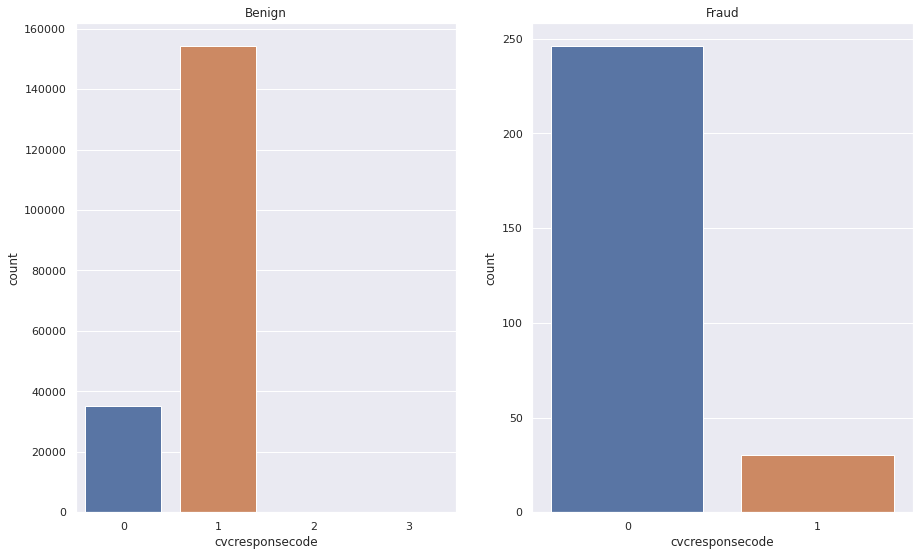

In [10]:
cvc_res_bn = df_src[df_src.label==0]
cvc_res_fr = df_src[df_src.label==1]
fig = plt.figure(figsize=(15,9))
plt.subplot(1,2,1)
sns.countplot(x='cvcresponsecode', data=cvc_res_bn)
plt.title('Benign')
plt.subplot(1,2,2)
sns.countplot(x='cvcresponsecode', data=cvc_res_fr)
plt.title('Fraud')
plt.show()

We can see here that in fraud records, ``cvcresponsecode`` is much more likely to be ``0`` (meaning "Unknown"), while benign records mostly have a ``cvcresponsecode`` of ``1`` (meaning "Match"). This means the validation result of the CVC/CVV2 code may serve as one important feature to detect fraud records.

## 2. Imbalance task – 1 A4 – Individual

In [ ]:
# load data
data_src = pd.read_csv('data/train_data.csv')
# data preprocessing
data_src = data_preprocessing(data_src)
data_src = data_src.drop(columns=['Id','amount', 'accountcode_cc', 'countries_equal'])
# data_src = data_src.drop(columns=['card_id','mail_id','ip_id'])
label_src = data_src['label']
data_src = data_src.drop(columns=['label'])
# split data
X_train, X_test, y_train, y_test = train_test_split(data_src, label_src, test_size=0.2, stratify=label_src)

In [ ]:
class MySMOTE:
    """
    MySMOTE is a class that implements the SMOTE algorithm.
    """
    def __init__(self, n = 1, k = 5):
        self.n = n # Amount of SMOTE n%
        self.k = k # Number of nearest neighbors
        self.new_index = 0 # Index counter for new samples
        self.synthetic = None # Synthetic samples
        if self.n < 1:
            raise ValueError("The sample rate n must be greater than 1")

    def fit_resample(self, sample, label):
        sample_column = sample.columns
        sample = sample.to_numpy()
        label = label.to_numpy()
        sample_minor = sample[label == 1]
        self.synthetic = np.zeros((sample_minor.shape[0] * self.n, sample_minor.shape[1]))
        for i in range(sample_minor.shape[0]):
            # Get the neighbors of the current sample
            neighbors = self.get_neighbors(sample_minor, sample_minor[i])
            self.populate(sample_minor, i, neighbors)
        synthetic_label = np.ones(self.synthetic.shape[0])
        # Concatenate the synthetic samples with the original samples
        synthetic = np.concatenate((sample, self.synthetic), axis=0)
        synthetic_label = np.concatenate((label, synthetic_label), axis=0)
        synthetic = pd.DataFrame(synthetic, columns=sample_column)
        synthetic_label = pd.Series(synthetic_label)
        return synthetic, synthetic_label

    def get_neighbors(self, X, x):
        """
        Get the k nearest neighbors of x in X.
        """
        distances = np.sqrt(np.sum((X - x)**2, axis=1))
        neighbors = np.argsort(distances)
        return neighbors[:self.k]

    def populate(self, sample, i, neighbors):
        for _ in range(self.n):
            # choose 1 neighbor at random
            nn = np.random.choice(neighbors)
            # create synthetic sample
            diff = sample[nn] - sample[i]
            gap = np.random.rand()
            self.synthetic[self.new_index] = sample[i] + gap * diff
            self.new_index += 1


### 2a. Print ROC curves
In this section, I choose KNN, Random Forest, and Bagging classifiers to evaluate the performance of the SMOTE algorithm.

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur
0,49.0,8.0,465943.0,1.0,49.0,1.0,1.0,1.0,3.0,152569.0,134648.0,49844.0,37.044337
1,49.0,8.0,475128.0,1.0,49.0,1.0,1.0,1.0,3.0,20295.0,20899.0,51514.0,72.407476
2,49.0,8.0,476224.0,1.0,49.0,1.0,1.0,1.0,3.0,154090.0,38294.0,104952.0,42.899545
3,49.0,8.0,475117.0,1.0,146.0,1.0,1.0,1.0,3.0,95039.0,141319.0,111479.0,65.450793
4,49.0,8.0,465943.0,1.0,49.0,1.0,1.0,1.0,3.0,146849.0,144742.0,128881.0,98.205176
5,49.0,2.0,543429.0,1.0,49.0,1.0,1.0,1.0,3.0,158879.0,48932.0,116838.0,33.565996
6,49.0,6.0,454638.0,1.0,49.0,1.0,1.0,1.0,3.0,149230.0,118383.0,111108.0,104.350246
7,49.0,2.0,542011.0,1.0,49.0,1.0,1.0,1.0,3.0,59546.0,157960.0,29847.0,25.507838
8,9.0,2.0,516310.0,0.0,9.0,1.0,1.0,0.0,0.0,96232.0,56512.0,132356.0,43.994721
9,49.0,8.0,476367.0,1.0,49.0,1.0,1.0,1.0,3.0,47614.0,101762.0,40405.0,26.261479


after SMOTE: 306402
Number of fraudulent transactions = 154921
Number of valid transactions = 151481
Training KNN..., please wait...


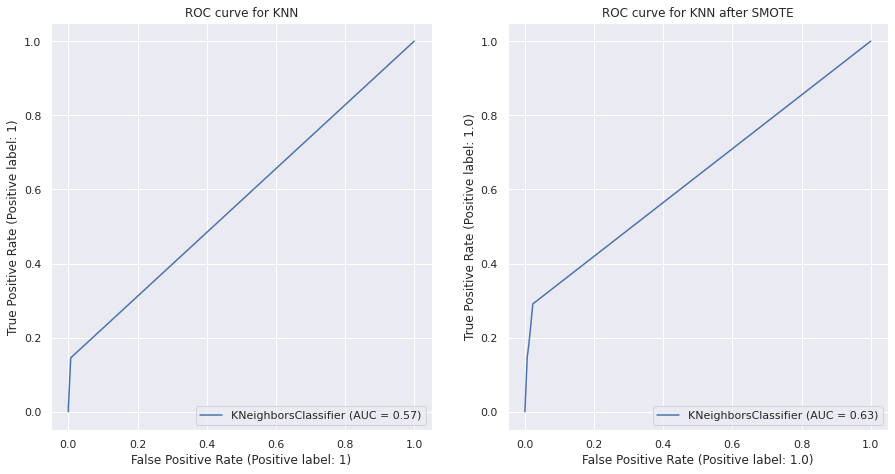

Training Random Forest..., please wait...


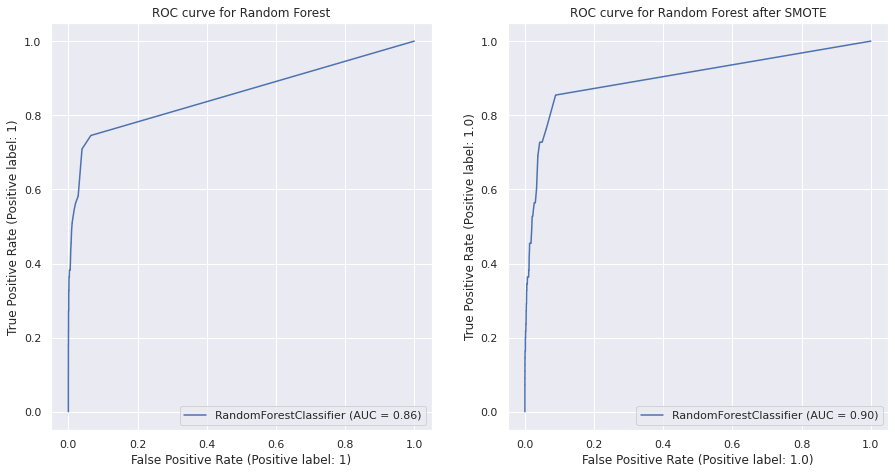

Training BaggingClassifier..., please wait...


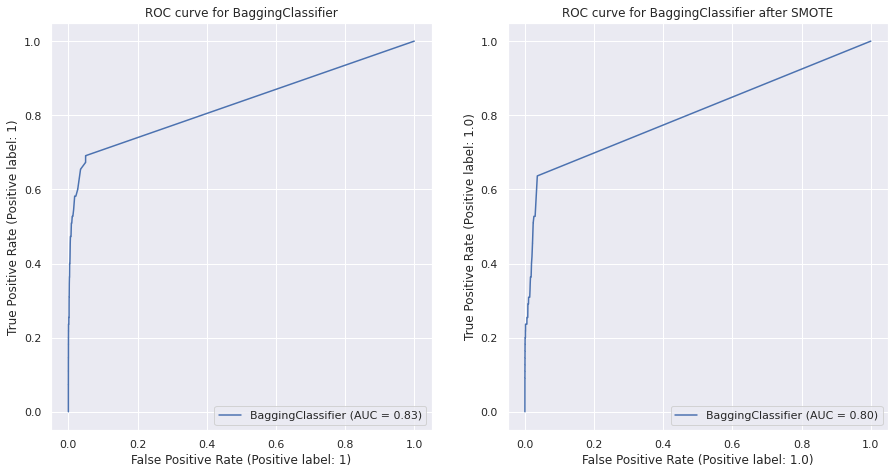

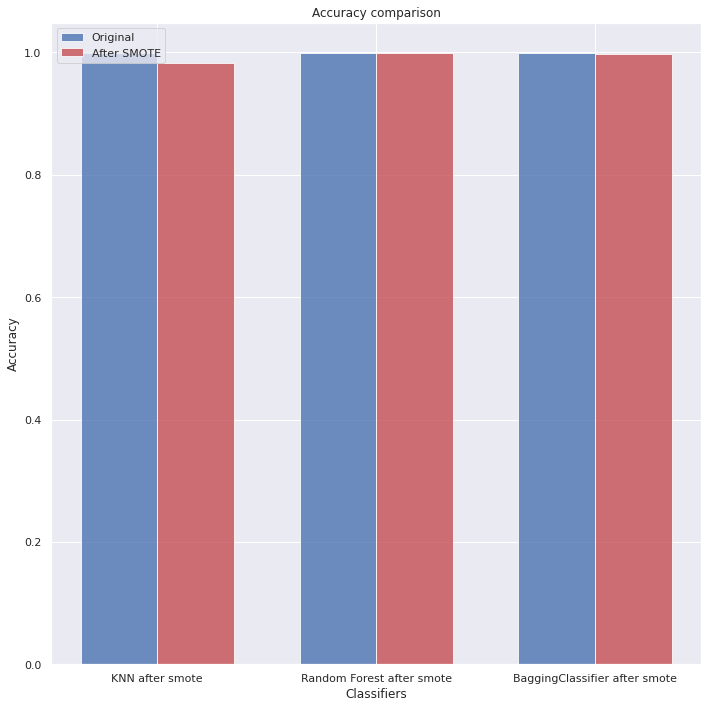

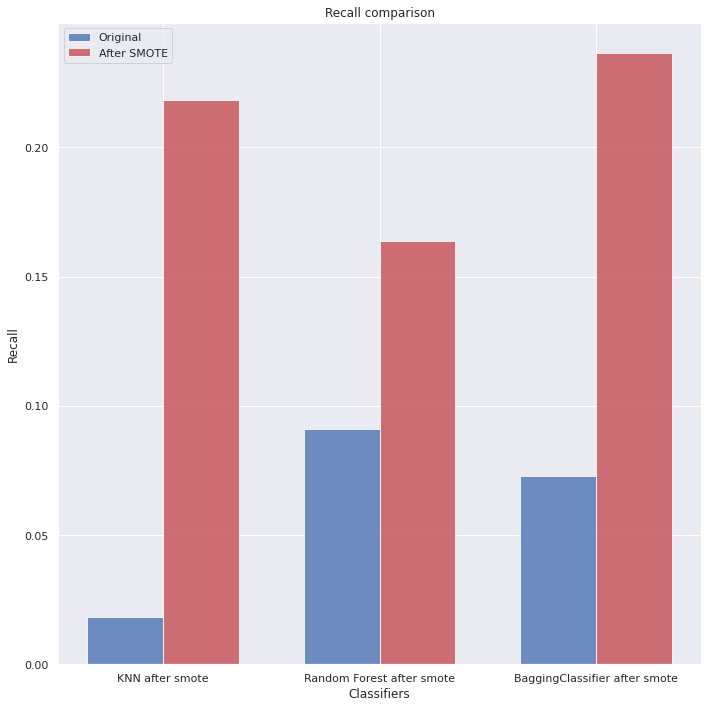

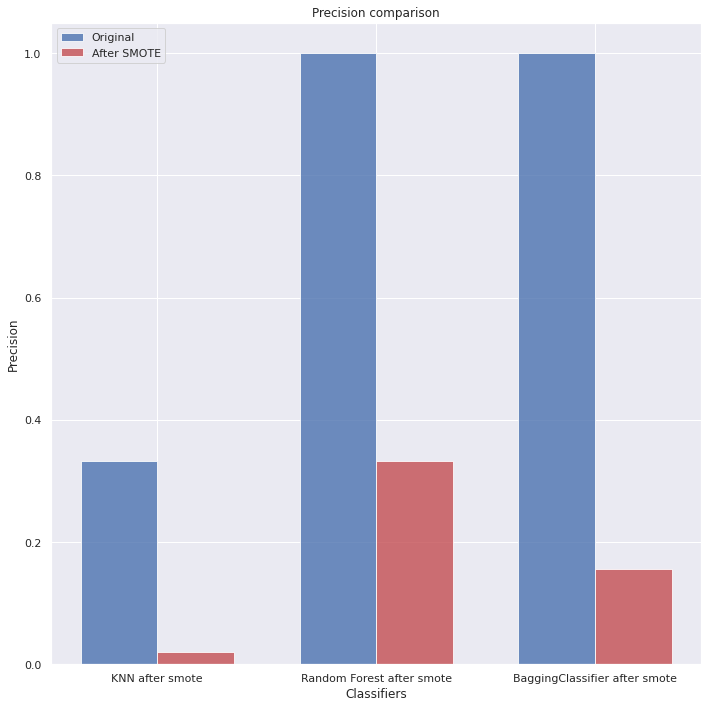

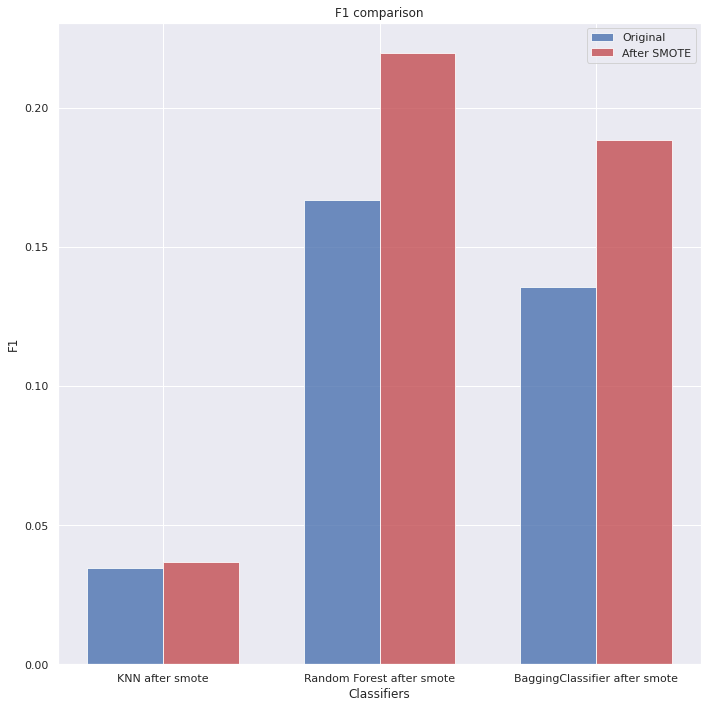

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
import sklearn.metrics as metrics

# init classifiers
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(n_estimators=200, random_state=0),
    BaggingClassifier(n_estimators=200)
]
classifiers_names = [
    'KNN',
    'Random Forest',
    'BaggingClassifier',
]
# init MySMOTE and use SMOTE to balance the data
sm = MySMOTE(n=700, k=3)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
display(X_train_sm.head(10))
print("after SMOTE:",len(X_train_sm))
print("Number of fraudulent transactions = " + str(len(y_train_sm.loc[y_train_sm == 1])))
print("Number of valid transactions = " + str(len(y_train_sm.loc[y_train_sm == 0])))

# init metrics
acc = []
acc_smote = []
recall = []
recall_smote = []
precision = []
precision_smote = []
f1 = []
f1_smote = []

# Training and evaluation
for clf, clf_name in zip(classifiers, classifiers_names):
    print("Training " + clf_name + "..., please wait...")

    # fit the classifier on the original training data
    clf.fit(X_train, y_train)

    # Plot RoC curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
    ax1.set_title('ROC curve for ' + clf_name)

    # collect metrics
    acc.append(clf.score(X_test, y_test))
    recall.append(metrics.recall_score(y_test, clf.predict(X_test)))
    precision.append(metrics.precision_score(y_test, clf.predict(X_test)))
    f1.append(metrics.f1_score(y_test, clf.predict(X_test)))

    # fit the classifier on the balanced training data
    clf.fit(X_train_sm, y_train_sm)

    # Plot RoC curve
    metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_title('ROC curve for ' + clf_name + ' after SMOTE')
    plt.show()

    # collect metrics
    acc_smote.append(clf.score(X_test, y_test))
    recall_smote.append(metrics.recall_score(y_test, clf.predict(X_test)))
    precision_smote.append(metrics.precision_score(y_test, clf.predict(X_test)))
    f1_smote.append(metrics.f1_score(y_test, clf.predict(X_test)))


classifiers_names_with_smote = [clf_name+" after smote" for clf_name in classifiers_names]
# multiple bar plot
def multiple_bar_plot(metrics, metrics_smote, metrics_names):
    fig, ax = plt.subplots()
    index = np.arange(len(classifiers_names))
    bar_width = 0.35
    opacity = 0.8
    error_config = {'ecolor': '0.3'}
    rects1 = plt.bar(index, metrics, bar_width,
                     alpha=opacity,
                     color='b',
                     error_kw=error_config,
                     label='Original')
    rects2 = plt.bar(index + bar_width, metrics_smote, bar_width,
                     alpha=opacity,
                     color='r',
                     error_kw=error_config,
                     label='After SMOTE')
    plt.xlabel('Classifiers')
    plt.ylabel(metrics_names)
    plt.title(metrics_names+' comparison')
    plt.xticks(index + bar_width/2, classifiers_names_with_smote)
    plt.legend()
    plt.tight_layout()
    plt.show()

multiple_bar_plot(acc, acc_smote, 'Accuracy')
multiple_bar_plot(recall, recall_smote, 'Recall')
multiple_bar_plot(precision, precision_smote, 'Precision')
multiple_bar_plot(f1, f1_smote, 'F1')

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

The figures above show the performance of the classifiers before and after SMOTE in terms of the AUC, accuracy, recall, precision, and F1 score.

In my opinion, the F1 score is the best metric to evaluate the performance of the classifiers.

F1 score is the harmonic mean of precision and recall. Precision in our case is the ratio of the real fraudulent transactions among the fraudulent transactions we predicted. Recall is the proportion of the fraudulent transactions that we detected. So, the F1 score is a good combination of precision and recall. A classifier with a higher F1 score is more likely to detect fraudulent transactions and avoid misclassifying benign transactions as fraudulent.

Therefore, based on the results above, the Random Forest classifier performs the best with the highest F1 score.


### 2c. Is using SMOTE a good idea? Why (not)?

In our scenario, SMOTE is a good idea. It will solve the imbalance problem and will help us to detect more fraudulent transactions, which is reflected in the Recall rate.

However, this method is too naive to generate synthetic data, reducing the precision rate of the classifier. But it can indeed relieve the imbalance.

## 3. Privacy task – 1 A4 – Individual

**Rank swapping** aims to protect privacy of providers of dataset. It first sorts all records of the dataset according to some feature. Then, each record will switch the value of this feature with a neighbor within a given range. By doing so, confidential information can be decoupled with identifiers.

In this part, rank swapping is implemented and tested on three different classifiers. ``ROC`` curves, ``AUC`` values, and ``f1`` scores are used to evaluate the performence of the classifers.


### 3a. Print ROC curves

#### Implement the rank swapping algorithm

In [12]:
import random

def rank_swapping(df, columns, p=1):
  '''
  rank swapping function
    df : (DataFrame) original dataframe
    columns : (list of string) columns for ranking and swapping
    p : range of swapping, p%, 0 <= p <= 100

    output : a swapped dataframe
  '''
  if p < 0 or p > 100:
    raise ValueError("value of p shall be within [0, 100]")

  df_ = df.copy()

  if p == 0:
    print("p = 0, no swapping is applied.")
    return df_ 

  print("Rank Swapping with the range of " + str(p) + "%")

  total_len = len(df_)
  swap_range = int(p * total_len // 100)
  # print("swap_range :" + str(swap_range))
  
  for col in columns:
    print("Swapping the attribute " + str(col) + "...")
    df_.sort_values(by=col, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    # extract one column (one attribute) from the data
    values = df_[col].copy()
    for idx in range(0, total_len):
      # lower and upper bounds of the swapping range
      lo = 0
      up = total_len - 1
      if idx - swap_range > 0:
        lo = idx - swap_range
      if idx + swap_range < total_len:
        up = idx + swap_range
      # the index of the value to be swapped with the current one
      idx_other = random.randint(lo, up)
      # swap the values
      values[idx], values[idx_other] = values[idx_other], values[idx]
    # update the swapping to the dataframe
    df_[col] = values

  print("rank swapping finished!")
  return df_

Apply rank swapping to the data.
First, load data.

In [13]:
data_src = pd.read_csv(os.path.join('data', 'train_data.csv'))
data_src = data_preprocessing(data_src)

# split dataset
  #drop deprecated columns
data_src = data_src.drop(columns=['Id','amount', 'accountcode_cc', 'countries_equal'])
label_src = data_src['label']
data_src = data_src.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(data_src, label_src, test_size=0.2)

#SMOTE the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train)


Apply rank swapping. Here ``amount_eur`` is confidential data, while identifier and quasi-identifiers include ``mail_id``, ``ip_id``, and ``card_id``.

In [14]:
#Apply rank swapping
X_train_swapped, y_train_swapped = X_train.copy(), y_train.copy()
X_train_swapped['label'] = y_train_swapped.copy()

#info to be swapped
info = ['amount_eur', 'ip_id', 'mail_id', 'card_id' ]
# surrounding records in the swapping range of 1%  may be swapped
X_train_swapped = rank_swapping(X_train_swapped, info, p=1) 
y_train_swapped = X_train_swapped['label'].copy()
X_train_swapped.drop(columns=['label'], inplace=True)

Rank Swapping with the range of 1%
Swapping the attribute amount_eur...
Swapping the attribute ip_id...
Swapping the attribute mail_id...
Swapping the attribute card_id...
rank swapping finished!


#### Training and Evaluation

Three classifers chosen here are ``Naive Bayes``, ``AdaBoost`` classifier, and ``Random Forest``.

Training Gaussian NB..., please wait...


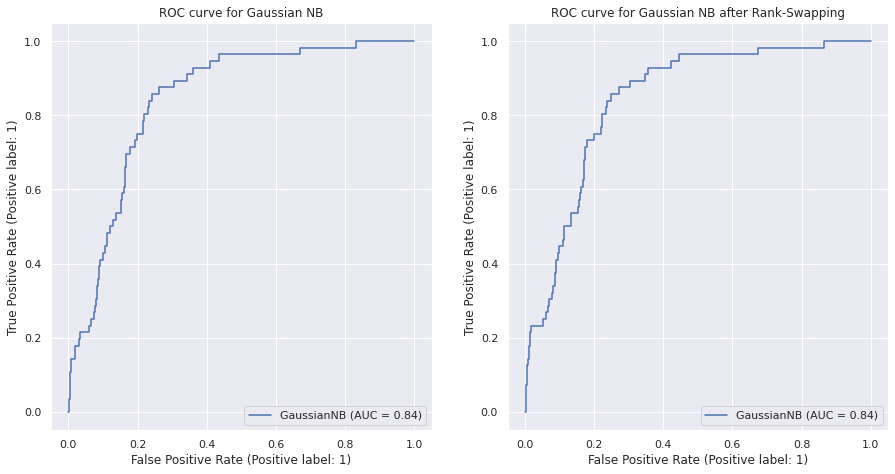

Training AdaBoost..., please wait...


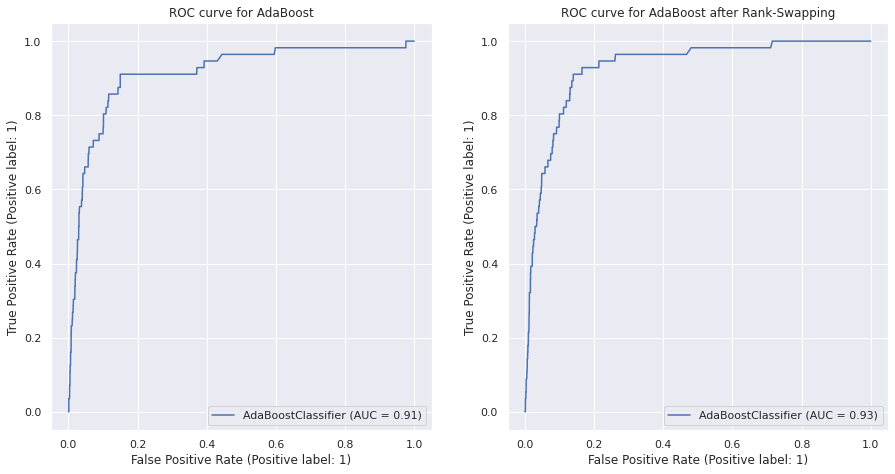

Training Random Forest..., please wait...


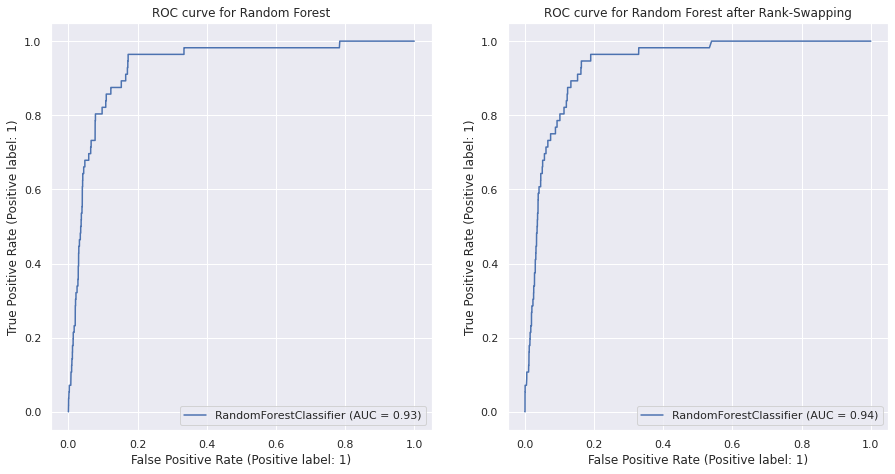

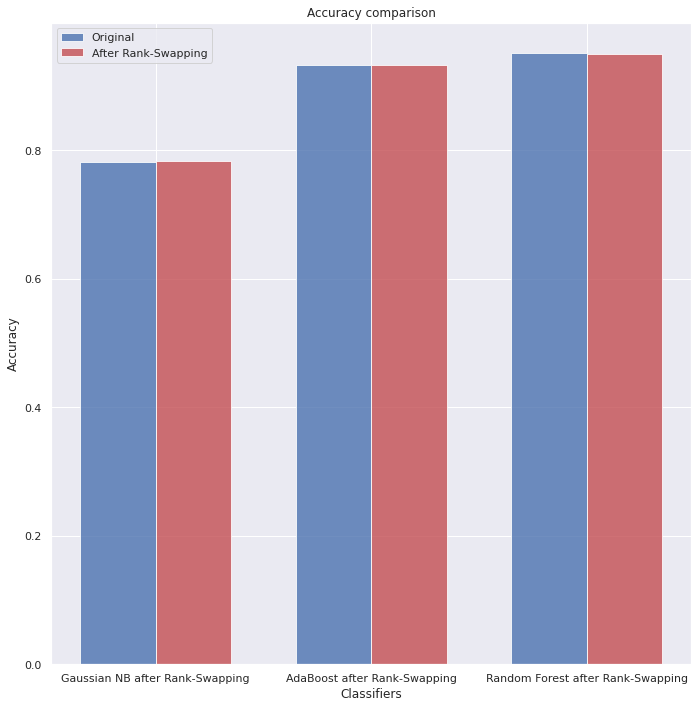

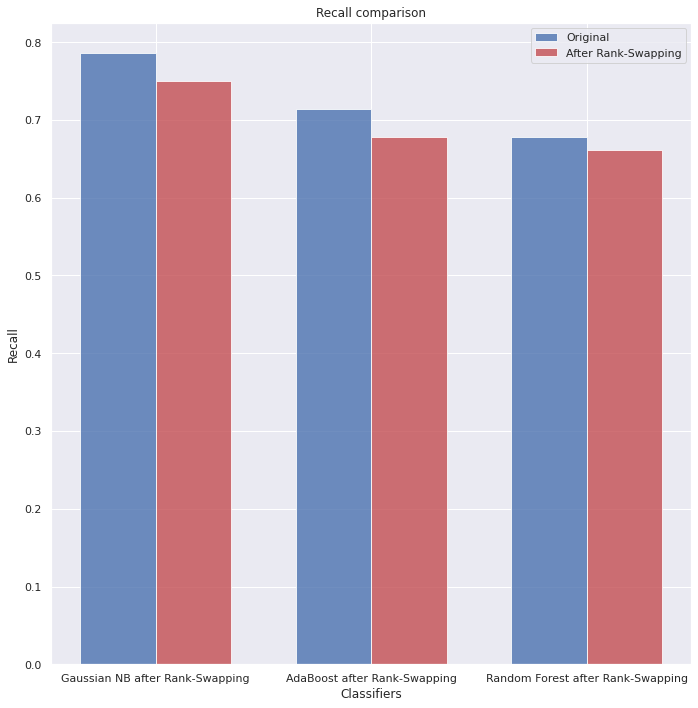

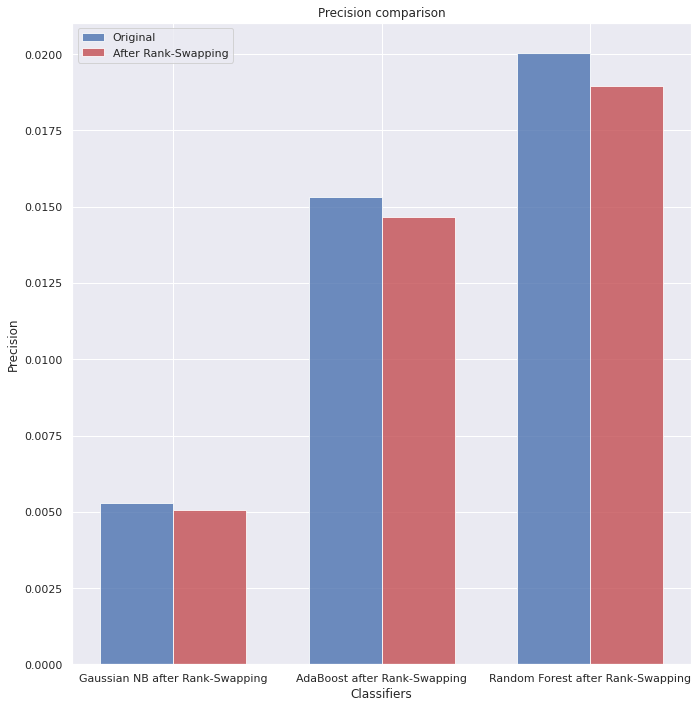

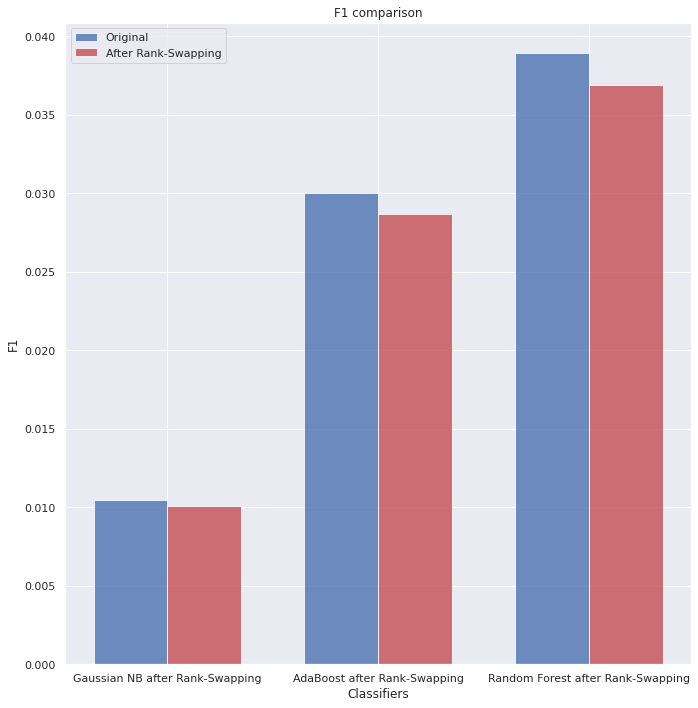

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

# init classifiers
classifiers = [
    GaussianNB(),
    AdaBoostClassifier(),
    RandomForestClassifier(n_estimators=100, max_depth=8)
]
classifiers_names = [
    'Gaussian NB',
    'AdaBoost',
    'Random Forest',
]

# init metrics
acc = []
acc_swapped = []
recall = []
recall_swapped = []
precision = []
precision_swapped = []
f1 = []
f1_swapped = []
# Training and evaluation
for clf, clf_name in zip(classifiers, classifiers_names):
    print("Training " + clf_name + "..., please wait...")

    # fit the classifier on the original training data
    clf.fit(X_train, y_train)

    # Plot RoC curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
    ax1.set_title('ROC curve for ' + clf_name)

    # collect metrics
    acc.append(clf.score(X_test, y_test))
    recall.append(metrics.recall_score(y_test, clf.predict(X_test)))
    precision.append(metrics.precision_score(y_test, clf.predict(X_test)))
    f1.append(metrics.f1_score(y_test, clf.predict(X_test)))

    # fit the classifier swapped data
    clf.fit(X_train_swapped, y_train_swapped)

    # Plot RoC curve
    metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_title('ROC curve for ' + clf_name + ' after Rank-Swapping')
    plt.show()

    # collect metrics
    acc_swapped.append(clf.score(X_test, y_test))
    recall_swapped.append(metrics.recall_score(y_test, clf.predict(X_test)))
    precision_swapped.append(metrics.precision_score(y_test, clf.predict(X_test)))
    f1_swapped.append(metrics.f1_score(y_test, clf.predict(X_test)))

classifiers_names_swapped = [clf_name+" after Rank-Swapping" for clf_name in classifiers_names]
# multiple bar plot
def multiple_bar_plot(metrics, metrics_swapped, metrics_names):
    fig, ax = plt.subplots()
    index = np.arange(len(classifiers_names))
    bar_width = 0.35
    opacity = 0.8
    error_config = {'ecolor': '0.3'}
    rects1 = plt.bar(index, metrics, bar_width,
                     alpha=opacity,
                     color='b',
                     error_kw=error_config,
                     label='Original')
    rects2 = plt.bar(index + bar_width, metrics_swapped, bar_width,
                     alpha=opacity,
                     color='r',
                     error_kw=error_config,
                     label='After Rank-Swapping')
    plt.xlabel('Classifiers')
    plt.ylabel(metrics_names)
    plt.title(metrics_names+' comparison')
    plt.xticks(index + bar_width/2, classifiers_names_swapped)
    plt.legend()
    plt.tight_layout()
    plt.show()

multiple_bar_plot(acc, acc_swapped, 'Accuracy')
multiple_bar_plot(recall, recall_swapped, 'Recall')
multiple_bar_plot(precision, precision_swapped, 'Precision')
multiple_bar_plot(f1, f1_swapped, 'F1')

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

From the results above, it can be observed that:

AUC : Random Forest > AdaBoost > Gaussian NB
f1 : Random Forest > AdaBoost > Gaussian NB

``f1`` score is an important metric here. A higher ``f1`` score means that more fraud is detected while fewer benign cases are misclassified, which is what we wish. Thus, it can be concluded that:

Performance : Random Forest > AdaBoost > Gaussian NB

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

The idea of Rank-swapping is to shuffle the original dataset within some constraints. So that an intruder cannot use it to determine confidential information on specific samples.

In the results above, no apparent drop in performance is observed after applying rank-swapping. This indicates that rank-swapping can protect privacy without hurting the performance too much. So it is advisable to use rank-swapping to protect privacy.

## 4. Classification task – 2 A4

Implemen the K-Fold cross validation with SMOTE.

In [55]:
from sklearn.model_selection import KFold, cross_validate
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import copy

def kf_validation(clf, df, plot_res=False, n_splits=10, smote=True, plot_AUC=False):
    """
    Our implementation of K-Fold cross validation
    :param clf: classifier
    :param df: source dataframe
    :param plot_res: if True, plot the results
    :param n_splits: number of splits
    :return: scores: a list of scores
    """
    # load data
    data_src = df.drop(columns=['Id', 'amount', 'accountcode_cc', 'countries_equal'])
    data_0 = data_src[data_src['label'] == 0]
    data_1 = data_src[data_src['label'] == 1]
    label_0 = data_0['label']
    label_1 = data_1['label']
    data_0 = data_0.drop(columns=['label'])
    data_1 = data_1.drop(columns=['label'])

    # KFold
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    sm = SMOTE(random_state=42)
    scores = dict()
    acc = []
    prec = []
    rec = []
    f1 = []
    auc = []
    best_clf, best_f1, X_test_best, y_test_best = None, 0, None, None
    for (train_index_0, test_index_0), (train_index_1, test_index_1) in zip(kf.split(data_0), kf.split(data_1)):
        X_train_0, X_test_0 = data_0.iloc[train_index_0], data_0.iloc[test_index_0]
        X_train_1, X_test_1 = data_1.iloc[train_index_1], data_1.iloc[test_index_1]
        y_train_0, y_test_0 = label_0.iloc[train_index_0], label_0.iloc[test_index_0]
        y_train_1, y_test_1 = label_1.iloc[train_index_1], label_1.iloc[test_index_1]
        # combine X_train_0 and X_train_1
        X_train = pd.concat([X_train_0, X_train_1], axis=0)
        y_train = pd.concat([y_train_0, y_train_1], axis=0)
        X_test = pd.concat([X_test_0, X_test_1], axis=0)
        y_test = pd.concat([y_test_0, y_test_1], axis=0)
        # SMOTE
        if smote:
            X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
            clf.fit(X_train_sm, y_train_sm)
        else:
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # scores
        acc.append(metrics.accuracy_score(y_test, y_pred))
        prec.append(metrics.precision_score(y_test, y_pred))
        rec.append(metrics.recall_score(y_test, y_pred))
        f1.append(metrics.f1_score(y_test, y_pred))
        auc.append(metrics.roc_auc_score(y_test, y_pred))
        if f1[-1] > best_f1:
            best_clf = copy.deepcopy(clf)
            best_f1 = f1[-1]
            X_test_best = X_test
            y_test_best = y_test
    if plot_res:
        plt.figure(figsize=(10, 10))
        plt.boxplot([acc, prec, rec, f1, auc])
        plt.xticks([1, 2, 3, 4, 5], ['accuracy', 'precision', 'recall', 'f1', 'auc'])
        if smote:
            plt.title(f'K-Fold Cross Validation of {clf.__class__.__name__} with SMOTE')
        else:
            plt.title(f'K-Fold Cross Validation of {clf.__class__.__name__} without SMOTE')
        plt.show()

    if plot_AUC:
        fig, ax = plt.subplots(figsize=(10, 10))
        metrics.RocCurveDisplay.from_estimator(best_clf, X_test_best, y_test_best, ax=ax)
        ax.set_title(f'ROC Curve of {best_clf.__class__.__name__}')
        plt.show()

    scores['acc'] = sum(acc) / len(acc)
    scores['prec'] = sum(prec) / len(prec)
    scores['rec'] = sum(rec) / len(rec)
    scores['f1'] = sum(f1) / len(f1)
    scores['auc'] = sum(auc) / len(auc)
    return scores, best_clf

### 4a. Print relevant plots and metrics with clear headings.

#### White Box - Decision Tree

A white-box model is explainable by design. A decision tree is by nature explainable and easy to understand, thus a typical white-box model. 

A decision tree is a tree in which each internal (non-leaf) node is labeled with an input feature. The arcs coming from a node labeled with an input feature are labeled with each of the possible values of the target feature or the arc leads to a subordinate decision node on a different input feature.

##### Construct decision tree and 10-fold validation

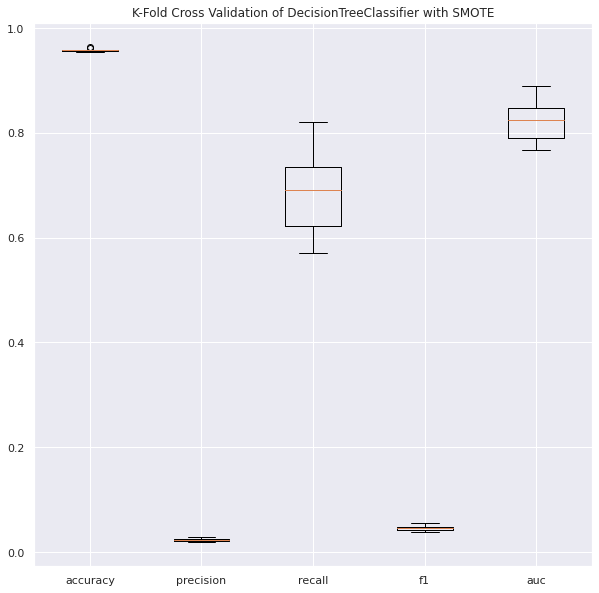

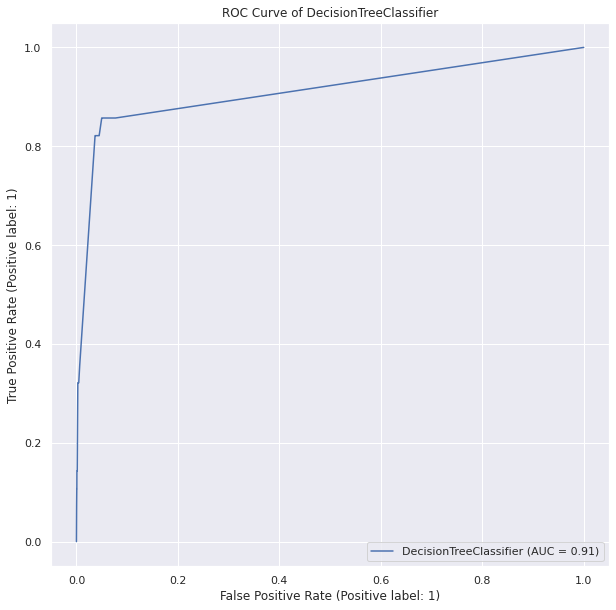

In [57]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

df_src = pd.read_csv(os.path.join('data', 'train_data.csv'))
df_src = data_preprocessing(df_src)

# construct a decision tree
dt = DecisionTreeClassifier(max_depth=10)
# run the 10-fold cross validation, plot the resulting scores
scores, best_dt = kf_validation(dt, df_src, plot_res=True, plot_AUC=True)

##### Explanation


Draw the final decision tree.



==================final decision tree=======================


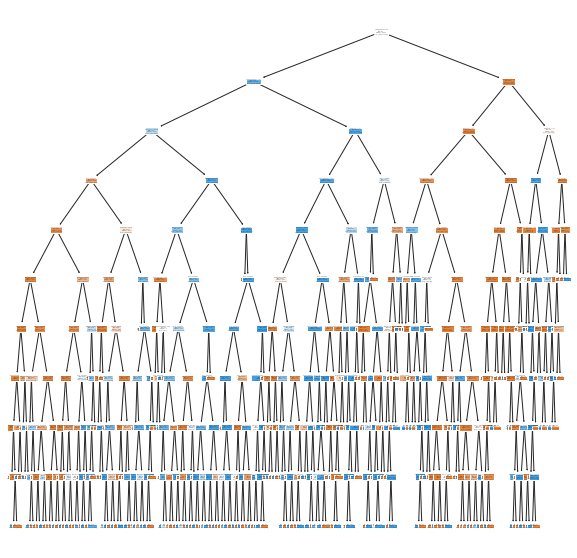

In [58]:
# extract feature names from original data set
data_src = df_src.drop(columns=['Id', 'amount', 'accountcode_cc', 'countries_equal', 'label'])
feat_names = data_src.columns
# plot the tree
class_names = ['benign', 'fraud']
print("==================final decision tree=======================")
display = plot_tree(best_dt, feature_names=feat_names, filled=True)

However, as we can see here, the full tree is so big and hard to see details clearly. It would be cumbersome to give a stepwise explanation for it. Of course, we can download a high-resolution version to check it. But we choose another way to observe it. We use ``feature importances``.

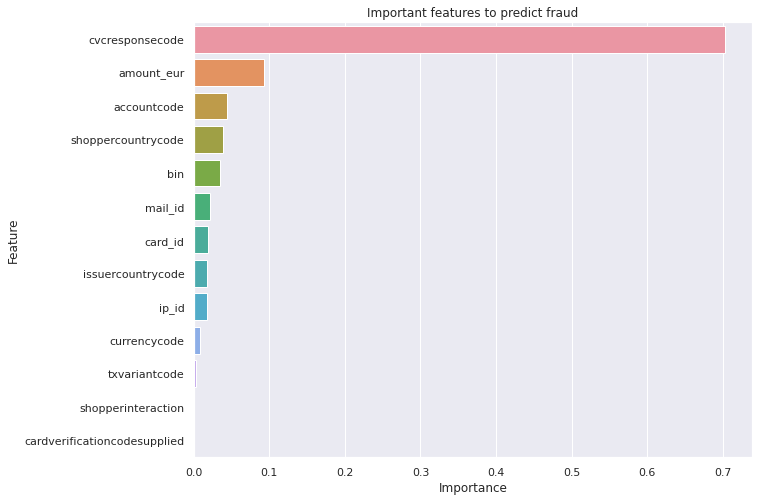

In [53]:
# feature map
feat_dict = {}

# extract the feature importance info from the trained decision tree
for col, val in sorted(zip(data_src.columns, best_dt.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

# visualization
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
sns.barplot(y=idx,x=values).set(title='Important features to predict fraud')
plt.show()

Now it can be clearly seen that, features like ``cvcresponsecode``, ``amount_eur`` play important roles in the decision makings. While information like ``mail_id``, ``ip_id`` is less relevant. This is consistent with common sense.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below

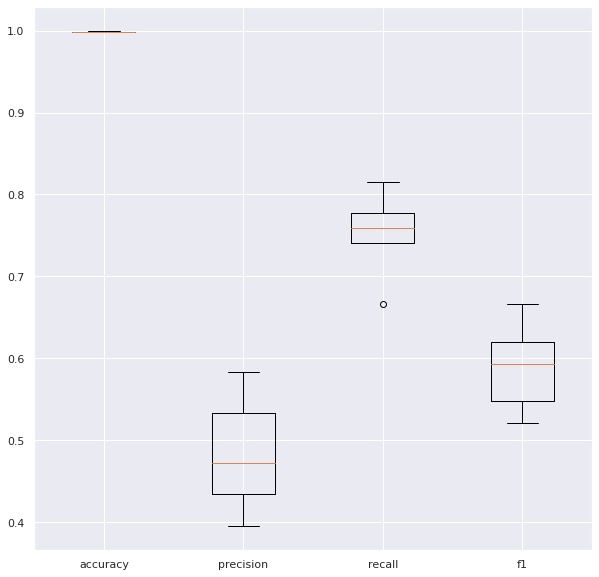

In [ ]:
from sklearn.model_selection import KFold
data_src = pd.read_csv('data/train_data.csv')
# data preprocessing
data_src = data_preprocessing(data_src)
data_src = data_src.drop(columns=['Id','amount', 'accountcode_cc', 'countries_equal'])
# data_src = data_src.drop(columns=['card_id','mail_id','ip_id'])

# count same mail_id
data_src['mail_id_count'] = data_src.groupby('mail_id')['mail_id'].transform('count')
# count same ip_id
data_src['ip_id_count'] = data_src.groupby('ip_id')['ip_id'].transform('count')
# count same card_id
data_src['card_id_count'] = data_src.groupby('card_id')['card_id'].transform('count')
# add all amount_eur using by same card_id
data_src['amount_eur_sum'] = data_src.groupby('card_id')['amount_eur'].transform('sum')
# add all amount_eur using by same email_id
data_src['amount_eur_sum_mail'] = data_src.groupby('mail_id')['amount_eur'].transform('sum')
# add all amount_eur using by same ip_id
data_src['amount_eur_sum_ip'] = data_src.groupby('ip_id')['amount_eur'].transform('sum')
# group by card_id and ip_id and count the same tuple
#data_src['card_ip_count'] = data_src.groupby(['card_id','ip_id']).transform('count')

data_src = data_src.drop(columns=['card_id','mail_id','ip_id'])
# label_src = data_src['label']
# data_src = data_src.drop(columns=['label'])
# n_splits = 10
# sm = SMOTE(random_state=0)
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
# acc = []
# prec = []
# rec = []
# f1 = []
# for train_index, test_index in kf.split(data_src):
#     X_train, X_test = data_src.iloc[train_index], data_src.iloc[test_index]
#     y_train, y_test = label_src.iloc[train_index], label_src.iloc[test_index]
#     X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
#     clf = RandomForestClassifier(n_estimators=10, random_state=0)
#     clf.fit(X_train_sm, y_train_sm)
#     y_pred = clf.predict(X_test)
#     acc.append(metrics.accuracy_score(y_test, y_pred))
#     prec.append(metrics.precision_score(y_test, y_pred))
#     rec.append(metrics.recall_score(y_test, y_pred))
#     f1.append(metrics.f1_score(y_test, y_pred))
# # plot boxplot
# plt.figure(figsize=(10,10))
# plt.boxplot([acc, prec, rec, f1])
# plt.xticks([1, 2, 3, 4], ['accuracy', 'precision', 'recall', 'f1'])
# plt.show()


label_src = data_src['label']
data_0 = data_src[data_src['label'] == 0]
data_1 = data_src[data_src['label'] == 1]
label_0 = data_0['label']
label_1 = data_1['label']
data_0 = data_0.drop(columns=['label'])
data_1 = data_1.drop(columns=['label'])
data_src = data_src.drop(columns=['label'])
n_splits = 10
sm = SMOTE(random_state=0)
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
acc = []
prec = []
rec = []
f1 = []

for (train_index_0, test_index_0), (train_index_1, test_index_1) in zip(kf.split(data_0), kf.split(data_1)):
    X_train_0, X_test_0 = data_0.iloc[train_index_0], data_0.iloc[test_index_0]
    X_train_1, X_test_1 = data_1.iloc[train_index_1], data_1.iloc[test_index_1]
    y_train_0, y_test_0 = label_0.iloc[train_index_0], label_0.iloc[test_index_0]
    y_train_1, y_test_1 = label_1.iloc[train_index_1], label_1.iloc[test_index_1]
    # combine X_train_0 and X_train_1
    X_train = pd.concat([X_train_0, X_train_1], axis=0)
    y_train = pd.concat([y_train_0, y_train_1], axis=0)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf = RandomForestClassifier(n_estimators=10, random_state=0)
    clf.fit(X_train_sm, y_train_sm)
    y_pred = clf.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    rec.append(metrics.recall_score(y_test, y_pred))
    f1.append(metrics.f1_score(y_test, y_pred))
# plot boxplot
plt.figure(figsize=(10,10))
plt.boxplot([acc, prec, rec, f1])
plt.xticks([1, 2, 3, 4], ['accuracy', 'precision', 'recall', 'f1'])
plt.show()

In [ ]:
rec

[0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7407407407407407,
 0.7407407407407407,
 0.7777777777777778,
 0.6666666666666666,
 0.8148148148148148,
 0.7407407407407407,
 0.7407407407407407]